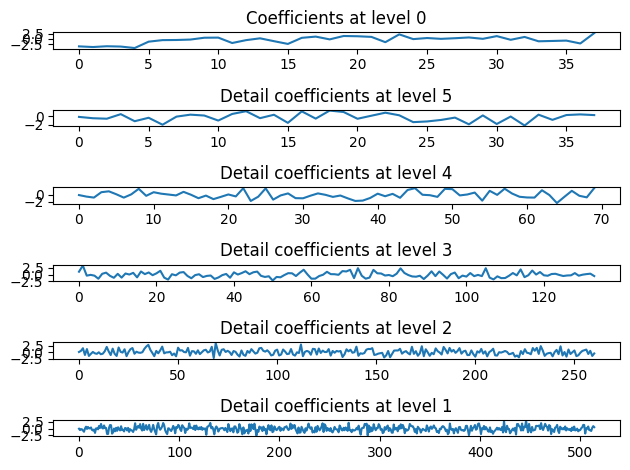

In [ ]:
# import numpy as np
# import pywt
# import matplotlib.pyplot as plt

# # Giả sử 'data' là tín hiệu EEG từ một kênh
# data = np.random.randn(1024)  # Tín hiệu giả lập cho ví dụ

# # Chọn loại sóng con và mức phân tích
# wavelet = 'db4'
# level = 5

# # Thực hiện phân tích sóng con
# coeffs = pywt.wavedec(data, wavelet, level=level)

# # Hiển thị các hệ số sóng con
# for i, coeff in enumerate(coeffs):
#     plt.subplot(len(coeffs), 1, i + 1)
#     plt.plot(coeff)
#     plt.title(f'Coefficients at level {i}' if i == 0 else f'Detail coefficients at level {level - i + 1}')

# plt.tight_layout()
# plt.show()


In [ ]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 50.8 MB/s eta 0:00:00


In [ ]:
!pip install scikit-plot

In [ ]:
import os
import mne
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt

# Read data from .set files
data_folder = '/content/drive/MyDrive/Data'

# Load participant labels
df_lb = pd.read_csv("/content/drive/MyDrive/Data/participants.tsv", delimiter='\t')

# Function to read EEG data from a .set file and extract epochs
def read_eeg_data(file_path):
    raw = mne.io.read_raw_eeglab(file_path)
    # Extract epochs (e.g., 4-second epochs with 2-second overlap)
    epochs = mne.make_fixed_length_epochs(raw, duration=4, overlap=0.5)
    return epochs


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
171 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 171 events and 2000 original time points ...
0 bad epochs dropped


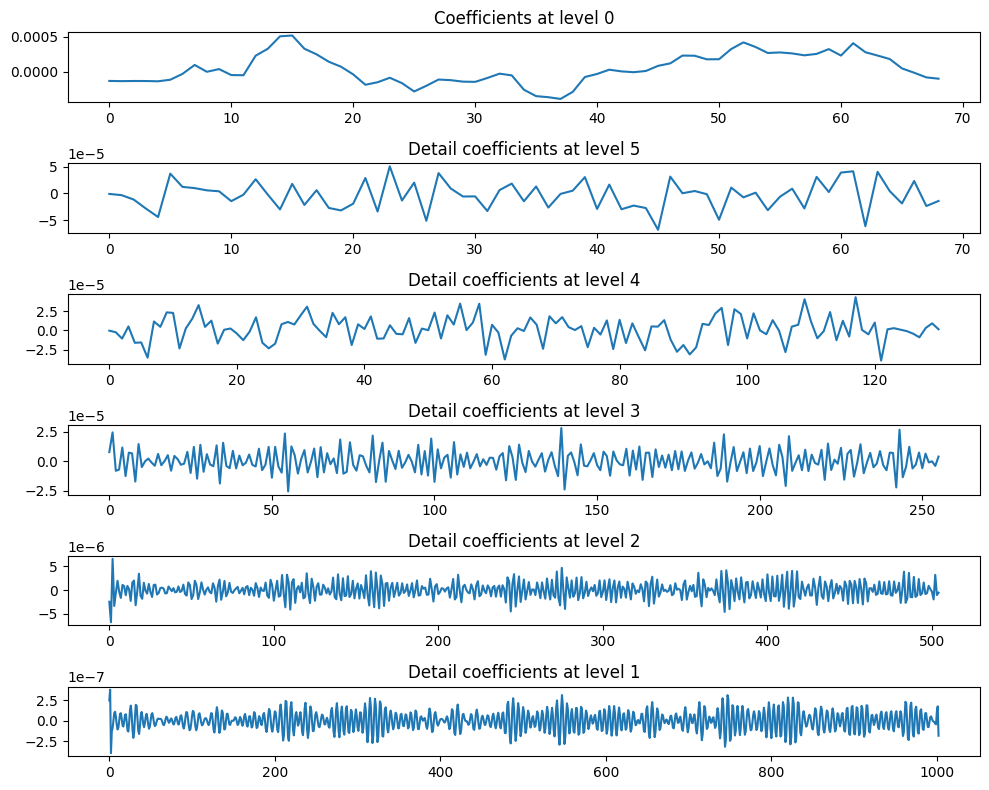

In [ ]:
def analysis_dwt(data):

    # Compute DWT features
    wavelet = 'db4'  # Choose a wavelet filter
    coeffs = pywt.wavedec(data, wavelet, level=5)  # DWT analysis

    # Plot all levels of coefficients
    plt.figure(figsize=(10, 8))
    for i, coeff in enumerate(coeffs):
        plt.subplot(len(coeffs), 1, i + 1)
        plt.plot(coeff)
        plt.title(f'Coefficients at level {i}' if i == 0 else f'Detail coefficients at level {5 - i + 1}')

    plt.tight_layout()
    plt.show()

# Example usage
file_path = os.path.join(data_folder, '/content/drive/MyDrive/Data/sub-001_task-eyesclosed_eeg.set')  # Adjust the file name as needed
epochs = read_eeg_data(file_path)
epoch_data = epochs.get_data()[0, 0, :]  # Lấy dữ liệu từ epoch đầu tiên và kênh đầu tiên
analysis_dwt(epoch_data)  # Hiển thị tất cả các hệ số sóng con một lần


# Feature extraction DWT

In [ ]:

# Function to compute DWT features for a given channel data
def compute_dwt_features(data):
    # Compute DWT features
    features = {}
    wavelet = 'db4'  # Choose a wavelet filter
    level = 5
    coeffs = pywt.wavedec(data, wavelet, level=level)  # DWT analysis


    # Calculate DWT features
    cD_Energy = np.mean([np.sum(np.square(coeffs[5])), np.sum(np.square(coeffs[4])),
                         np.sum(np.square(coeffs[3])), np.sum(np.square(coeffs[2])),
                         np.sum(np.square(coeffs[1]))])
    cA_Energy = np.sum(np.square(coeffs[0]))
    D_Entropy = np.mean([np.sum(np.square(coeffs[5]) * np.log(np.square(coeffs[5]))),
                         np.sum(np.square(coeffs[4]) * np.log(np.square(coeffs[4]))),
                         np.sum(np.square(coeffs[3]) * np.log(np.square(coeffs[3]))),
                         np.sum(np.square(coeffs[2]) * np.log(np.square(coeffs[2]))),
                         np.sum(np.square(coeffs[1]) * np.log(np.square(coeffs[1])))])

    A_Entropy = np.sum(np.square(coeffs[0]) * np.log(np.square(coeffs[0])))
    D_mean = np.mean([np.mean(coeffs[5]), np.mean(coeffs[4]), np.mean(coeffs[3]), np.mean(coeffs[2]), np.mean(coeffs[1])])
    A_mean = np.mean(coeffs[0])
    D_std = np.mean([np.std(coeffs[5]), np.std(coeffs[4]), np.std(coeffs[3]), np.std(coeffs[2]), np.std(coeffs[1])])
    A_std = np.std(coeffs[0])

    # Store features
    features = {
        'cD_Energy': cD_Energy,
        'cA_Energy': cA_Energy,
        'D_std': D_std,
        'A_std': A_std,
        'D_mean': D_mean,
        'A_mean': A_mean,
        'D_Entropy': D_Entropy,
        'A_Entropy': A_Entropy,
    }

    return features



# List to store DWT features and labels
features_list = []
labels_list = []

# Iterate through files in the data folder
for filename in os.listdir(data_folder):
    if filename.endswith('.set'):
        # Extract participant ID from filename
        participant_id = filename.split("_")[0]

        # Get label for the participant from the dataframe
        label = df_lb[df_lb['participant_id'] == participant_id]['Group'].values[0]

        # Read EEG data and extract epochs
        file_path = os.path.join(data_folder, filename)
        epochs = read_eeg_data(file_path)

        # Extract DWT features for each epoch and each channel
        for epoch_data in epochs.get_data():
            epoch_features = {}
            for i, channel_data in enumerate(epoch_data):
                # Compute DWT features for each channel
                channel_features = compute_dwt_features(channel_data)
                for feature_name, feature_value in channel_features.items():
                    epoch_features[f'Channel_{i+1}_{feature_name}'] = feature_value

            # Append features and label to the lists
            features_list.append(epoch_features)
            labels_list.append(label)

# Convert features and labels lists to DataFrame
features_df = pd.DataFrame(features_list)
features_df['label'] = labels_list

# Print size of the features DataFrame
print("Size of DWT features DataFrame:", features_df.shape)




Not setting metadata
171 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 171 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
226 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 2000 original time points ...
0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 87 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
201 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 201 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
229 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 229 events and 2000 original time points ...
0 bad epochs dropped
Not setting metadata
180 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 180 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
218 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 218 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
226 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
174 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 174 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
366 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 366 events and 2000 original time points ...
0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


219 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 219 events and 2000 original time points ...
0 bad epochs dropped
Not setting metadata
252 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 252 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
239 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 239 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
266 matching events found
No baseline correction applied


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 projection items activated
Using data from preloaded Raw for 266 events and 2000 original time points ...
0 bad epochs dropped
Not setting metadata
257 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 257 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
277 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 277 events and 2000 original time points ...
0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 240 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
241 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 241 events and 2000 original time points ...
0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
262 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 262 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
248 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 248 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
262 matching events found


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 262 events and 2000 original time points ...
0 bad epochs dropped
Not setting metadata
234 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 234 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
238 matching events found


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 238 events and 2000 original time points ...
0 bad epochs dropped
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 216 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
195 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 195 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
256 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 256 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
235 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 235 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
233 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 233 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
210 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 210 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
158 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 158 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 328 events and 2000 original time points ...
0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
227 matching events found


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 227 events and 2000 original time points ...
0 bad epochs dropped
Not setting metadata
201 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 201 events and 2000 original time points ...
0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
276 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 276 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
211 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 211 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 240 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
221 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 221 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
254 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 254 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
242 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 242 events and 2000 original time points ...
0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
275 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 275 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
253 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 253 events and 2000 original time points ...
0 bad epochs dropped
Not setting metadata
275 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 275 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
236 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 236 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
251 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 251 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
243 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 243 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
215 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 215 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
230 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 230 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
282 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 282 events and 2000 original time points ...
0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
222 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 222 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
233 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 233 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
215 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 215 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
217 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 217 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
222 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 222 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
239 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 239 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


232 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 232 events and 2000 original time points ...
0 bad epochs dropped
Not setting metadata
225 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
227 matching events found
No baseline correction applied


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)


0 projection items activated
Using data from preloaded Raw for 227 events and 2000 original time points ...
0 bad epochs dropped
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 216 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
213 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 213 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
229 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 229 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
256 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 256 events and 2000 original time points ...
0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
229 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 229 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
242 matching events found
No baseline correction applied


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 projection items activated
Using data from preloaded Raw for 242 events and 2000 original time points ...
0 bad epochs dropped
Not setting metadata
252 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 252 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 2000 original time points ...
0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
183 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 183 events and 2000 original time points ...
0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
163 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 163 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
181 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 181 events and 2000 original time points ...
0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 136 events and 2000 original time points ...
0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
176 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 176 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
187 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 187 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
244 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 244 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
289 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 289 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
213 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 213 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
233 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 233 events and 2000 original time points ...
0 bad epochs dropped
Not setting metadata
199 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 199 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
248 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 248 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
233 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 233 events and 2000 original time points ...
0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
261 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 261 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
235 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 235 events and 2000 original time points ...
0 bad epochs dropped
Not setting metadata
222 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 222 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
260 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 260 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
186 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 186 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
159 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 159 events and 2000 original time points ...
0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
165 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 165 events and 2000 original time points ...
0 bad epochs dropped


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


Not setting metadata
172 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 172 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 2000 original time points ...


<ipython-input-3-3291b14fac88>:16: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(file_path)
<ipython-input-3-3291b14fac88>:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path)


0 bad epochs dropped
Size of DWT features DataFrame: (19894, 153)


In [ ]:
features_df

,Channel_1_cD_Energy,Channel_1_cA_Energy,Channel_1_D_std,Channel_1_A_std,Channel_1_D_mean,Channel_1_A_mean,Channel_1_D_Entropy,Channel_1_A_Entropy,Channel_2_cD_Energy,Channel_2_cA_Energy,...,Channel_18_A_Entropy,Channel_19_cD_Energy,Channel_19_cA_Energy,Channel_19_D_std,Channel_19_A_std,Channel_19_D_mean,Channel_19_A_mean,Channel_19_D_Entropy,Channel_19_A_Entropy,label
0,2.180046e-08,3.306781e-06,0.000011,0.000214,-3.487309e-07,4.706580e-05,-4.630478e-07,-0.000054,1.720100e-08,3.126527e-06,...,-0.000046,1.320297e-08,2.798026e-06,0.000008,0.000198,-2.240653e-08,3.900435e-05,-2.797143e-07,-0.000046,A
1,2.222881e-08,2.640970e-06,0.000011,0.000195,4.798163e-07,2.016266e-05,-4.728172e-07,-0.000044,1.837596e-08,2.316507e-06,...,-0.000038,1.349511e-08,2.344583e-06,0.000008,0.000183,6.533809e-07,2.109498e-05,-2.816722e-07,-0.000039,A
2,2.423164e-08,1.399766e-06,0.000011,0.000131,-9.930797e-07,-5.566337e-05,-5.098493e-07,-0.000024,2.162126e-08,1.460454e-06,...,-0.000026,1.295265e-08,1.484044e-06,0.000008,0.000134,-2.764446e-07,-5.898641e-05,-2.742917e-07,-0.000025,A
3,2.230395e-08,2.488357e-06,0.000011,0.000190,-2.803706e-07,-8.793887e-06,-4.725783e-07,-0.000041,1.672568e-08,2.654725e-06,...,-0.000048,8.875973e-09,3.004718e-06,0.000007,0.000208,2.907810e-07,-1.701242e-05,-1.924527e-07,-0.000049,A
4,1.939146e-08,9.098650e-07,0.000010,0.000115,6.548938e-08,-1.869514e-06,-4.108535e-07,-0.000016,1.721546e-08,9.208050e-07,...,-0.000015,9.077565e-09,8.183200e-07,0.000007,0.000108,-2.773277e-07,1.252788e-05,-1.975884e-07,-0.000014,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19889,2.026831e-08,2.140156e-06,0.000010,0.000176,6.365903e-07,-1.375789e-05,-4.170429e-07,-0.000036,2.059784e-08,2.112850e-06,...,-0.000036,1.069177e-08,2.081913e-06,0.000007,0.000174,3.997060e-07,-5.042938e-06,-2.296961e-07,-0.000035,F
19890,2.074116e-08,1.642225e-06,0.000010,0.000154,-5.133101e-07,3.449780e-06,-4.277108e-07,-0.000028,2.176891e-08,1.656990e-06,...,-0.000029,1.771193e-08,1.560993e-06,0.000009,0.000150,6.173377e-07,5.228441e-06,-3.673761e-07,-0.000027,F
19891,1.806211e-08,1.965030e-06,0.000010,0.000169,3.499302e-08,-4.754396e-06,-3.758749e-07,-0.000033,1.970037e-08,1.947383e-06,...,-0.000035,1.294215e-08,2.074059e-06,0.000008,0.000173,6.450503e-07,-4.342434e-06,-2.739632e-07,-0.000034,F
19892,1.942783e-08,1.777306e-06,0.000010,0.000160,-3.563784e-07,9.278938e-08,-4.025175e-07,-0.000030,1.907074e-08,1.851005e-06,...,-0.000029,1.131453e-08,1.743518e-06,0.000008,0.000159,-5.114195e-07,-6.993279e-06,-2.410960e-07,-0.000029,F


# Vẽ biều đồ histogram

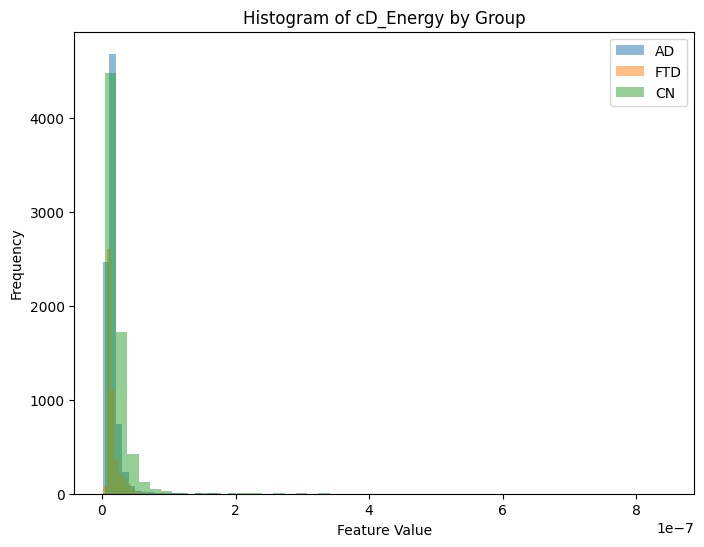

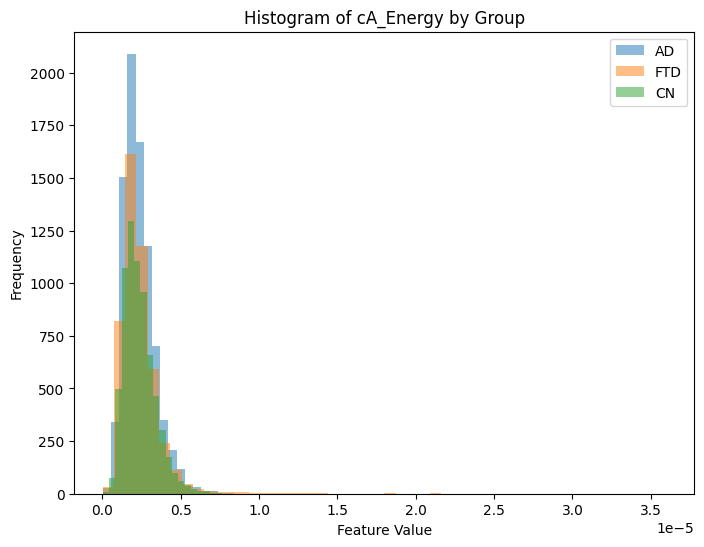

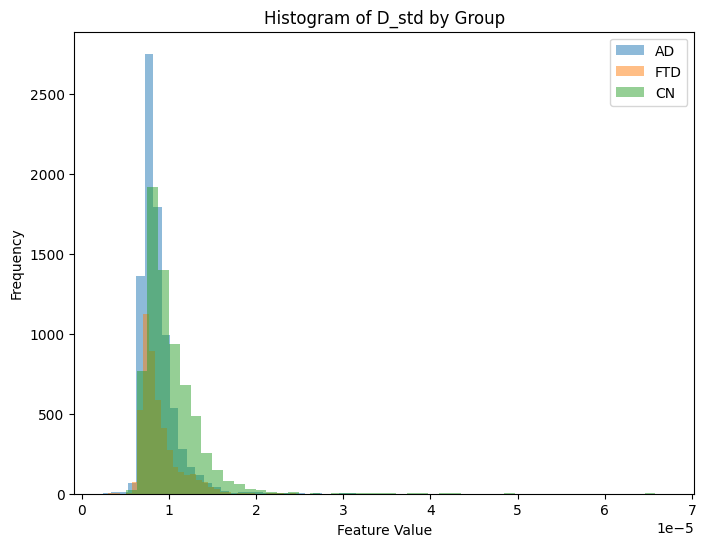

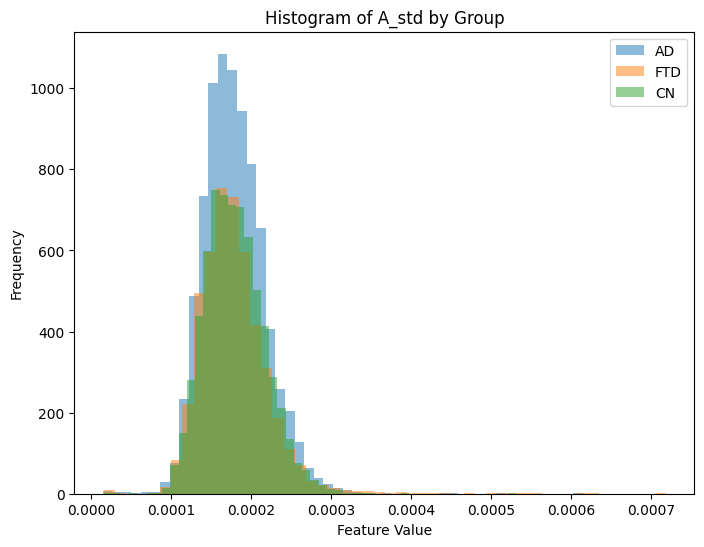

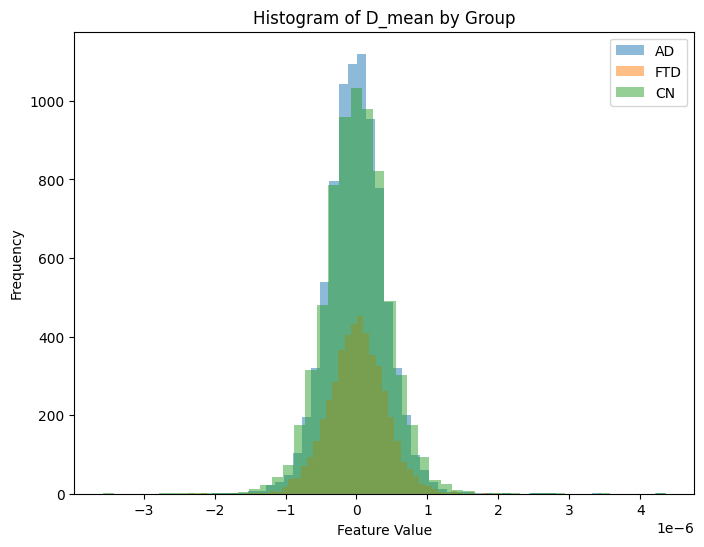

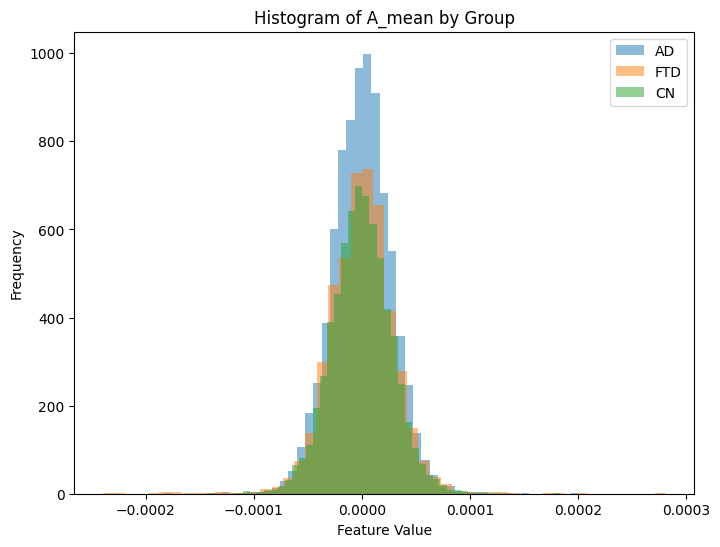

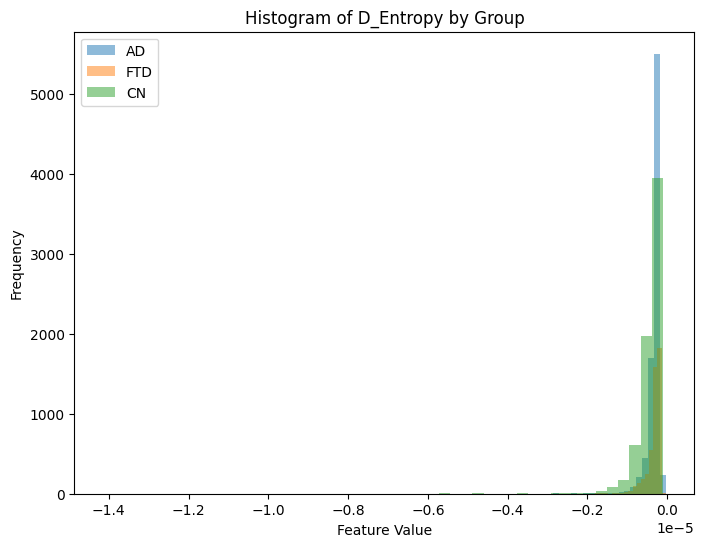

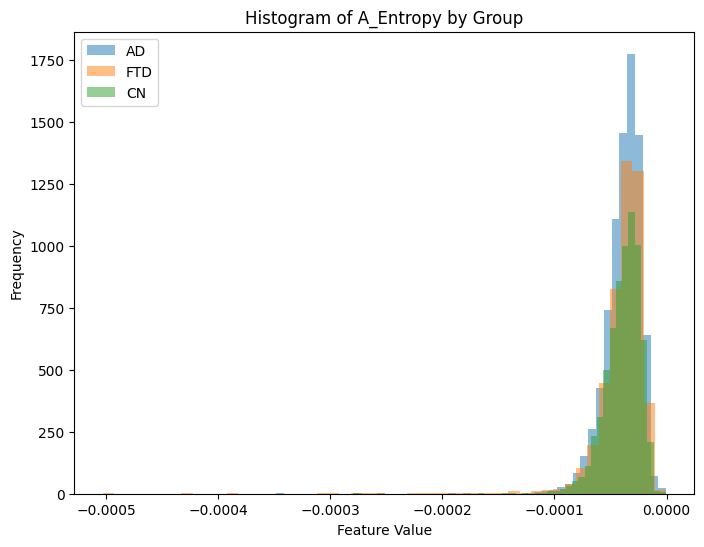

In [ ]:
# import matplotlib.pyplot as plt

# # Chọn các đặc trưng  muốn vẽ histogram
# selected_features = ['cD_Energy', 'cA_Energy', 'D_std', 'A_std', 'D_mean', 'A_mean', 'D_Entropy', 'A_Entropy']

# # Định nghĩa các nhóm nhãn
# label_mapping = {'A': 'AD', 'F': 'FTD', 'C': 'CN'}

# # Vẽ histogram cho mỗi đặc trưng
# for feature in selected_features:
#     plt.figure(figsize=(8, 6))
#     for label, group_name in label_mapping.items():
#         # Tạo tên cột mới bằng cách thêm đuôi 'feature' vào các nhãn
#         new_feature_name = f'Channel_{i+1}_{feature}'
#         plt.hist(features_df[new_feature_name][features_df['label'] == label], bins=50, alpha=0.5, label=group_name)
#     plt.xlabel('Feature Value')
#     plt.ylabel('Frequency')
#     plt.title(f'Histogram of {feature} by Group')
#     plt.legend()
#     plt.show()


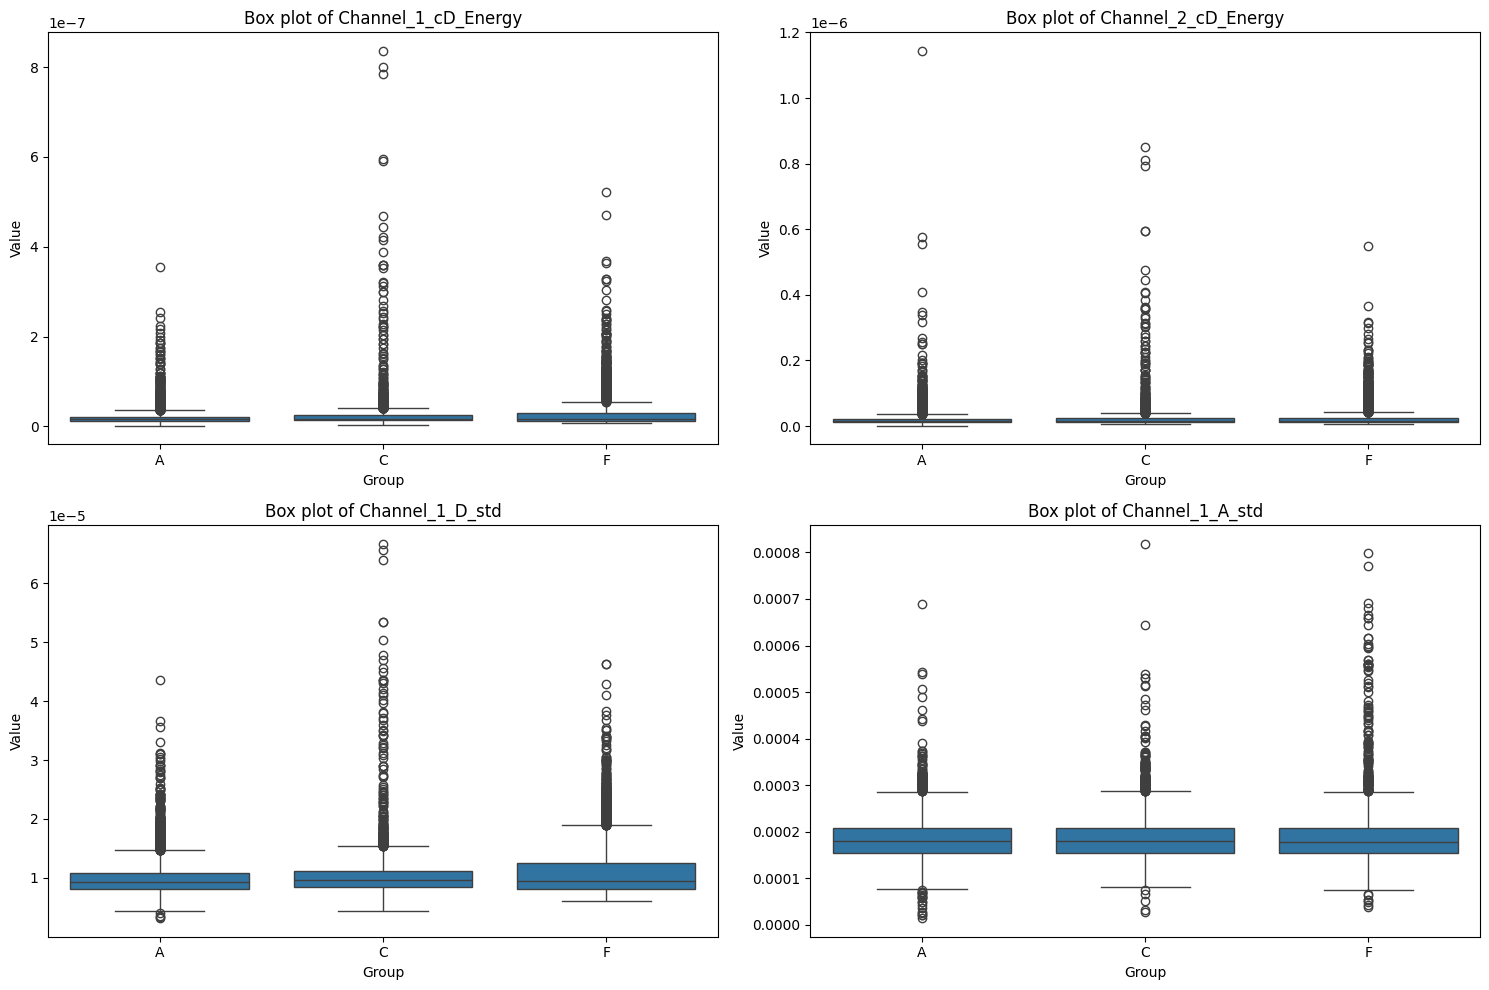

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Chọn một vài đặc trưng tiêu biểu để hiển thị
# selected_features = ['Channel_1_cD_Energy','Channel_1_cA_Energy',
#                      'Channel_1_D_std', 'Channel_1_A_std']

# # Tạo box plots cho từng đặc trưng
# plt.figure(figsize=(15, 10))
# for i, feature in enumerate(selected_features):
#     plt.subplot(2, 2, i+1)
#     sns.boxplot(x='label', y=feature, data=features_df)
#     plt.title(f'Box plot of {feature}')
#     plt.xlabel('Group')
#     plt.ylabel('Value')
# plt.tight_layout()
# plt.show()


# Vẽ biều đồ box-plot



<ipython-input-7-129f158f32aa>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=feature, data=average_features, palette=palette)
<ipython-input-7-129f158f32aa>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=feature, data=average_features, palette=palette)
<ipython-input-7-129f158f32aa>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=feature, data=average_features, palette=palette)
<ipython-input-7-129f158f32aa>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will b

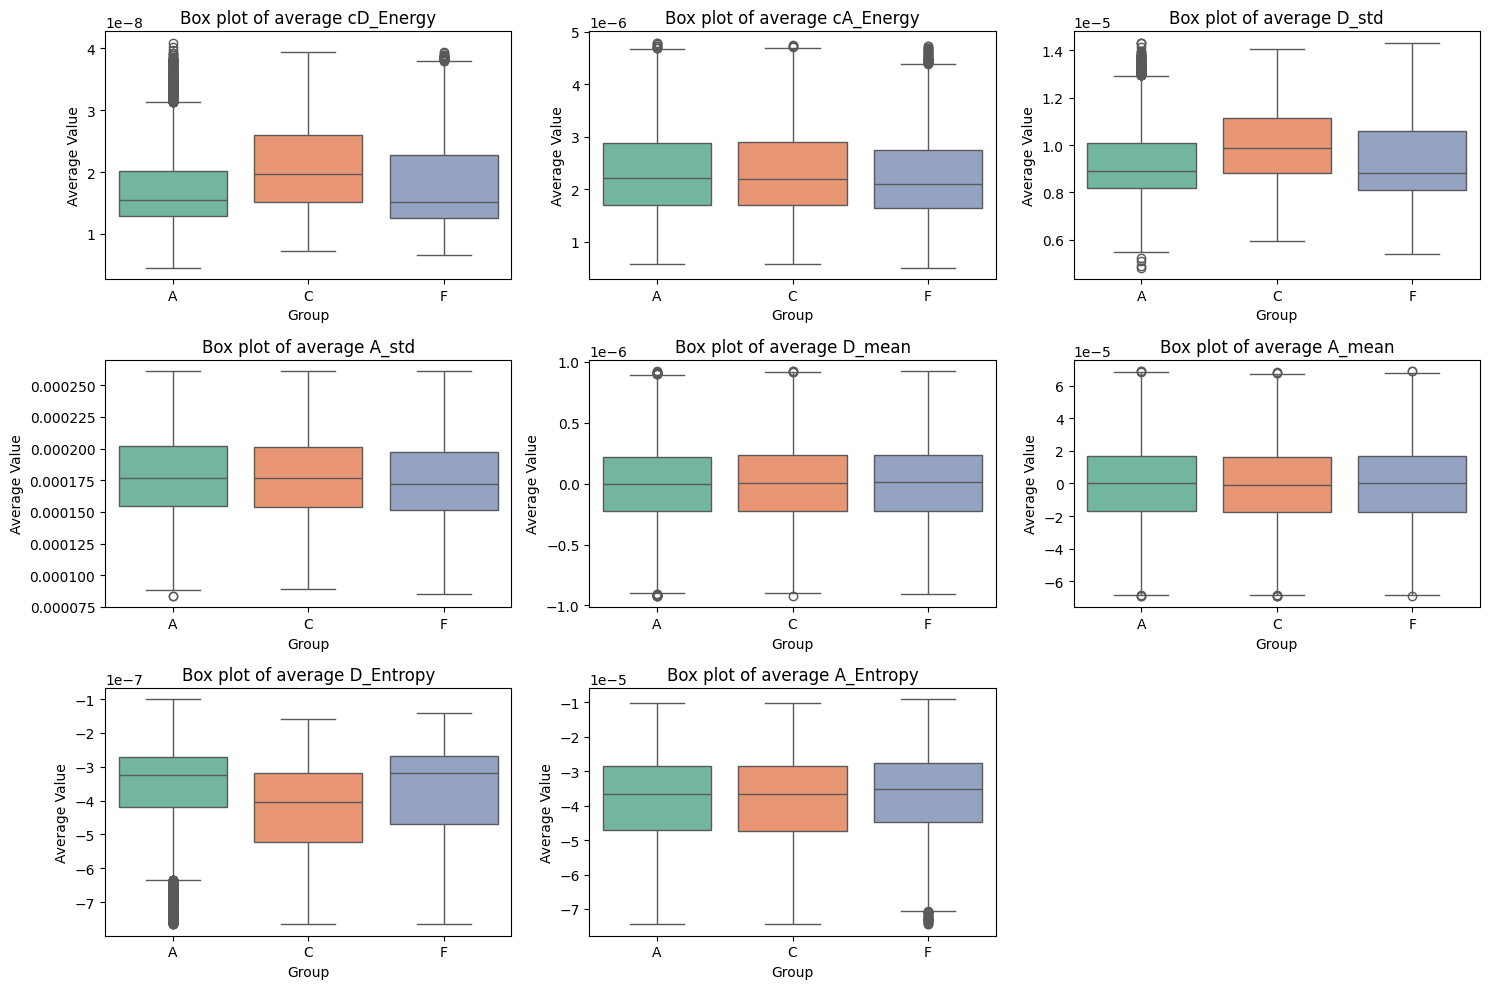

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Tạo một danh sách các đặc trưng cần tính trung bình
feature_names = ['cD_Energy', 'cA_Energy', 'D_std', 'A_std', 'D_mean', 'A_mean', 'D_Entropy', 'A_Entropy']

# Tạo một DataFrame mới để lưu trữ giá trị trung bình của các đặc trưng trên tất cả các kênh
average_features = pd.DataFrame()

# Tính giá trị trung bình cho từng đặc trưng trên tất cả các kênh
for feature in feature_names:
    channel_features = [f'Channel_{i+1}_{feature}' for i in range(19)]
    average_features[feature] = features_df[channel_features].mean(axis=1)

# Thêm cột nhãn
average_features['label'] = features_df['label']

# Loại bỏ outliers bằng phương pháp IQR
def remove_outliers(df, feature_names):
    for feature in feature_names:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df

average_features = remove_outliers(average_features, feature_names)

# Định nghĩa bảng màu
palette = "Set2"  # Bạn có thể chọn bảng màu khác như "Set1", "Set3", "Pastel1", v.v.

# Vẽ box plot cho các giá trị trung bình của từng đặc trưng theo nhóm bệnh
plt.figure(figsize=(15, 10))
for i, feature in enumerate(feature_names):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='label', y=feature, data=average_features, palette=palette)
    plt.title(f'Box plot of average {feature}')
    plt.xlabel('Group')
    plt.ylabel('Average Value')
plt.tight_layout()
plt.show()


<ipython-input-20-510faae8d900>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=feature, data=average_features, palette=palette)
<ipython-input-20-510faae8d900>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=feature, data=average_features, palette=palette)
<ipython-input-20-510faae8d900>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=feature, data=average_features, palette=palette)
<ipython-input-20-510faae8d900>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and wi

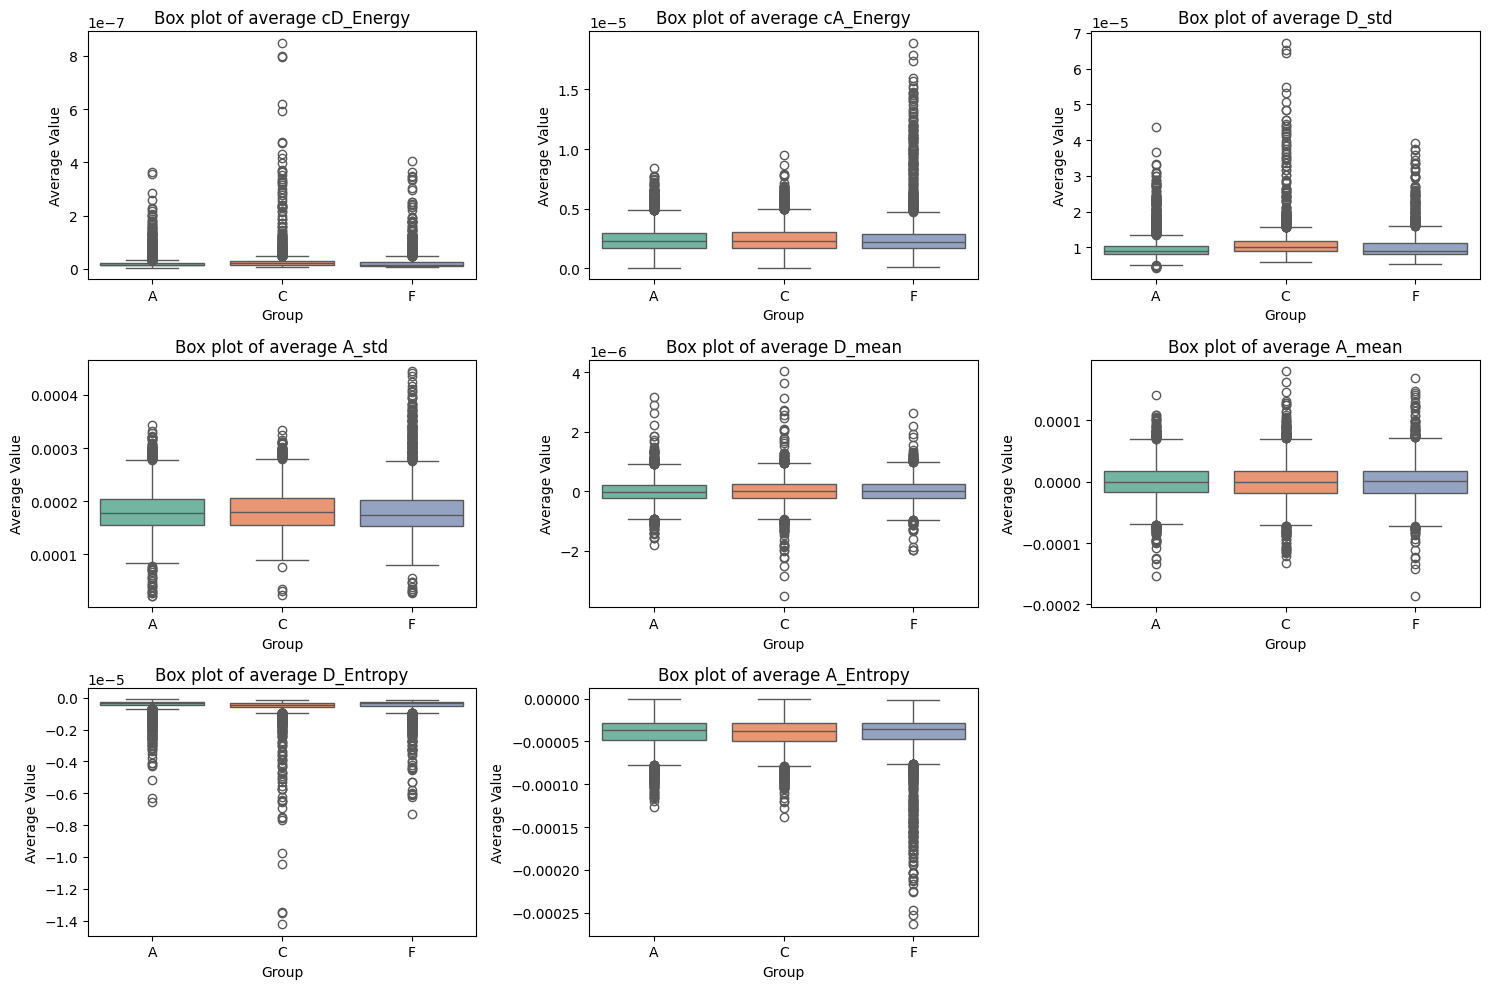

In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Tạo một danh sách các đặc trưng cần tính trung bình
# feature_names = ['cD_Energy', 'cA_Energy', 'D_std', 'A_std', 'D_mean', 'A_mean', 'D_Entropy', 'A_Entropy']

# # Tạo một DataFrame mới để lưu trữ giá trị trung bình của các đặc trưng trên tất cả các kênh
# average_features = pd.DataFrame()

# # Tính giá trị trung bình cho từng đặc trưng trên tất cả các kênh
# for feature in feature_names:
#     channel_features = [f'Channel_{i+1}_{feature}' for i in range(19)]
#     average_features[feature] = features_df[channel_features].mean(axis=1)


# # Thêm cột nhãn
# average_features['label'] = features_df['label']

# # Định nghĩa bảng màu
# palette = "Set2"  # Bạn có thể chọn bảng màu khác như "Set1", "Set3", "Pastel1", v.v.

# # Vẽ box plot cho các giá trị trung bình của từng đặc trưng theo nhóm bệnh
# plt.figure(figsize=(15, 10))
# for i, feature in enumerate(feature_names):
#     plt.subplot(3, 3, i+1)
#     sns.boxplot(x='label', y=feature, data=average_features, palette=palette)
#     plt.title(f'Box plot of average {feature}')
#     plt.xlabel('Group')
#     plt.ylabel('Average Value')
# plt.tight_layout()
# plt.show()


# Kết hợp đặc trưng RBP và DWT

In [ ]:
bands = {'Delta': [0.5, 4],
         'Theta': [4, 8],
         'Alpha': [8, 13],
         'Beta': [13, 25],
         'Gamma': [25, 45]}

In [ ]:
# Load RBP features DataFrame
rbp_features_all_loaded = np.load('/content/rbp_features_all.npy')

# Convert loaded RBP features to DataFrame
rbp_features_df = pd.DataFrame(rbp_features_all_loaded.reshape(-1, rbp_features_all_loaded.shape[1] * rbp_features_all_loaded.shape[2]))

# Rename columns of the RBP features DataFrame
rbp_features_df.columns = [f'RBP_{band}_{channel}' for band in bands.keys() for channel in range(rbp_features_all_loaded.shape[2])]

# Concatenate RBP features and DWT features
combined_features_df = pd.concat([features_df, rbp_features_df], axis=1)

# Print size of the combined features DataFrame
print("Size of combined features DataFrame:", combined_features_df.shape)


Size of combined features DataFrame: (19894, 248)


# ANOVA and kruskal-wallis

In [ ]:
# from scipy.stats import f_oneway, kruskal

# # Chia dữ liệu thành các nhóm tương ứng với các nhãn (labels)
# grouped_data = [features_df[features_df['label'] == label] for label in features_df['label'].unique()]

# # Thực hiện ANOVA
# anova_results = {}
# for column in features_df.columns[:-1]:  # Loại bỏ cột 'label'
#     anova_results[column] = f_oneway(*[group[column] for group in grouped_data])

# # Thực hiện Kruskal-Wallis test
# kruskal_results = {}
# for column in features_df.columns[:-1]:  # Loại bỏ cột 'label'
#     kruskal_results[column] = kruskal(*[group[column] for group in grouped_data])

# # In kết quả
# for column, result in anova_results.items():
#     print(f"ANOVA for {column}: F-statistic = {result.statistic}, p-value = {result.pvalue}")

# for column, result in kruskal_results.items():
#     print(f"Kruskal-Wallis test for {column}: Statistic = {result.statistic}, p-value = {result.pvalue}")


ANOVA for Channel_1_cD_Energy: F-statistic = 226.32079749596002, p-value = 6.483236582429086e-98
ANOVA for Channel_1_cA_Energy: F-statistic = 20.707999199117033, p-value = 1.0374806421545383e-09
ANOVA for Channel_1_D_std: F-statistic = 256.29697798308047, p-value = 1.2638039652671533e-110
ANOVA for Channel_1_A_std: F-statistic = 6.738010838122999, p-value = 0.001187708582016204
ANOVA for Channel_1_D_mean: F-statistic = 1.415082479010079, p-value = 0.24293003061783575
ANOVA for Channel_1_A_mean: F-statistic = 0.09355550919318857, p-value = 0.9106878652220372
ANOVA for Channel_1_D_Entropy: F-statistic = 268.4516005955356, p-value = 9.092269508867817e-116
ANOVA for Channel_1_A_Entropy: F-statistic = 18.221448960410758, p-value = 1.2409825628625195e-08
ANOVA for Channel_2_cD_Energy: F-statistic = 58.72845705554827, p-value = 3.7116345467551756e-26
ANOVA for Channel_2_cA_Energy: F-statistic = 4.718285222394782, p-value = 0.00894047672969188
ANOVA for Channel_2_D_std: F-statistic = 61.307940

In [ ]:
combined_features_df

,Channel_1_cD_Energy,Channel_1_cA_Energy,Channel_1_D_std,Channel_1_A_std,Channel_1_D_mean,Channel_1_A_mean,Channel_1_D_Entropy,Channel_1_A_Entropy,Channel_2_cD_Energy,Channel_2_cA_Energy,...,RBP_Gamma_9,RBP_Gamma_10,RBP_Gamma_11,RBP_Gamma_12,RBP_Gamma_13,RBP_Gamma_14,RBP_Gamma_15,RBP_Gamma_16,RBP_Gamma_17,RBP_Gamma_18
0,2.180046e-08,3.306781e-06,0.000011,0.000214,-3.487309e-07,4.706580e-05,-4.630478e-07,-0.000054,1.720100e-08,3.126527e-06,...,0.003978,0.010147,0.003965,0.018784,0.002958,0.003185,0.003847,0.002279,0.002574,0.002436
1,2.222881e-08,2.640970e-06,0.000011,0.000195,4.798163e-07,2.016266e-05,-4.728172e-07,-0.000044,1.837596e-08,2.316507e-06,...,0.006047,0.004231,0.002315,0.004964,0.005736,0.003875,0.005503,0.003395,0.002173,0.002328
2,2.423164e-08,1.399766e-06,0.000011,0.000131,-9.930797e-07,-5.566337e-05,-5.098493e-07,-0.000024,2.162126e-08,1.460454e-06,...,0.006815,0.008336,0.009004,0.006872,0.004950,0.007769,0.006455,0.008406,0.004766,0.004733
3,2.230395e-08,2.488357e-06,0.000011,0.000190,-2.803706e-07,-8.793887e-06,-4.725783e-07,-0.000041,1.672568e-08,2.654725e-06,...,0.002755,0.001877,0.001675,0.001849,0.001932,0.001914,0.002577,0.002069,0.001519,0.001365
4,1.939146e-08,9.098650e-07,0.000010,0.000115,6.548938e-08,-1.869514e-06,-4.108535e-07,-0.000016,1.721546e-08,9.208050e-07,...,0.012636,0.008105,0.008521,0.007312,0.008794,0.009686,0.009430,0.012206,0.008476,0.008604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19889,2.026831e-08,2.140156e-06,0.000010,0.000176,6.365903e-07,-1.375789e-05,-4.170429e-07,-0.000036,2.059784e-08,2.112850e-06,...,0.001428,0.002173,0.001518,0.000894,0.001180,0.000839,0.001648,0.001267,0.002221,0.001176
19890,2.074116e-08,1.642225e-06,0.000010,0.000154,-5.133101e-07,3.449780e-06,-4.277108e-07,-0.000028,2.176891e-08,1.656990e-06,...,0.002839,0.009543,0.001867,0.003688,0.002593,0.003436,0.003479,0.003656,0.005056,0.002858
19891,1.806211e-08,1.965030e-06,0.000010,0.000169,3.499302e-08,-4.754396e-06,-3.758749e-07,-0.000033,1.970037e-08,1.947383e-06,...,0.009989,0.012225,0.008387,0.009974,0.007994,0.010409,0.011202,0.004703,0.011703,0.008509
19892,1.942783e-08,1.777306e-06,0.000010,0.000160,-3.563784e-07,9.278938e-08,-4.025175e-07,-0.000030,1.907074e-08,1.851005e-06,...,0.006384,0.005441,0.003001,0.003390,0.004099,0.004340,0.007541,0.002496,0.007737,0.004827


# Classification RF vs DWT

In [ ]:
# Tìm chỉ mục của các mẫu không phải là 'F'
indices = features_df[features_df['label'] != 'F'].index

# Lấy dữ liệu mới mà loại bỏ các mẫu có nhãn là 'F'
X_full_AC = features_df.loc[indices]
y_full_AC = features_df['label'].loc[indices]


In [ ]:
# Tìm chỉ mục của các mẫu không phải là 'A'
indices = features_df[features_df['label'] != 'A'].index

# Lấy dữ liệu mới mà loại bỏ các mẫu có nhãn là 'A'
X_full_FC = features_df.loc[indices]
y_full_FC = features_df['label'].loc[indices]


In [ ]:
# Tìm chỉ mục của các mẫu không phải là 'C'
indices = features_df[features_df['label'] != 'C'].index

# Lấy dữ liệu mới mà loại bỏ các mẫu có nhãn là 'C'
X_full_AF = features_df.loc[indices]
y_full_AF = features_df['label'].loc[indices]


Accuracy: 0.7847725774555043
Classification Report:
              precision    recall  f1-score   support

           A       0.77      0.87      0.82      1702
           C       0.81      0.67      0.73      1332

    accuracy                           0.78      3034
   macro avg       0.79      0.77      0.78      3034
weighted avg       0.79      0.78      0.78      3034



<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

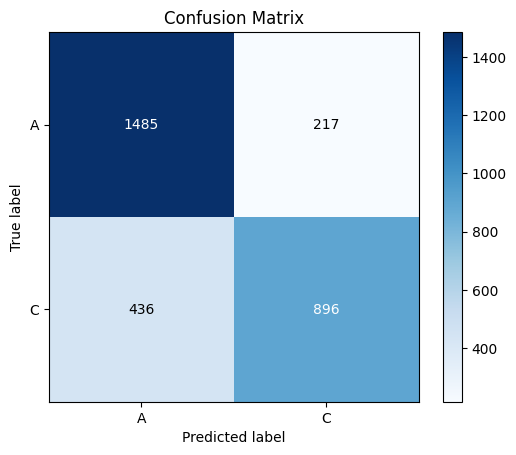

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import scikitplot as skplt

# Tách features và labels
X = X_full_AC.drop('label', axis=1)
y = y_full_AC

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Xây dựng và huấn luyện mô hình Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Dự đoán nhãn cho dữ liệu kiểm tra
y_pred = rf_model.predict(X_test)

# Đánh giá hiệu suất của mô hình
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# In báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, y_pred))


skplt.metrics.plot_confusion_matrix(y_test, y_pred)


Accuracy: 0.8029322984044847
Classification Report:
              precision    recall  f1-score   support

           C       0.81      0.88      0.84      1409
           F       0.78      0.69      0.73       910

    accuracy                           0.80      2319
   macro avg       0.80      0.78      0.79      2319
weighted avg       0.80      0.80      0.80      2319



<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

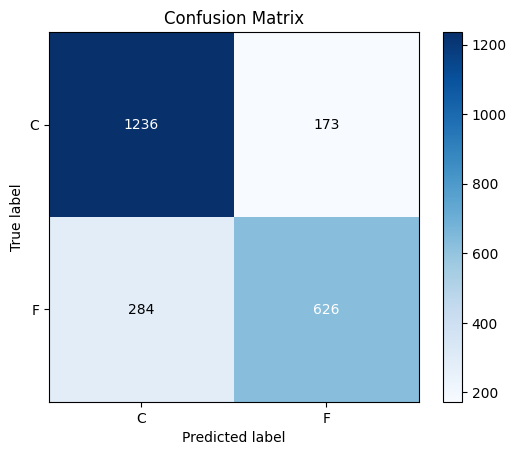

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import scikitplot as skplt

# Tách features và labels
X = X_full_FC.drop('label', axis=1)
y = y_full_FC

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Xây dựng và huấn luyện mô hình Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Dự đoán nhãn cho dữ liệu kiểm tra
y_pred = rf_model.predict(X_test)

# Đánh giá hiệu suất của mô hình
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# In báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, y_pred))

skplt.metrics.plot_confusion_matrix(y_test, y_pred)


Accuracy: 0.7362763915547025
Classification Report:
              precision    recall  f1-score   support

           A       0.72      0.96      0.82      1639
           F       0.85      0.35      0.50       966

    accuracy                           0.74      2605
   macro avg       0.78      0.66      0.66      2605
weighted avg       0.77      0.74      0.70      2605



<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

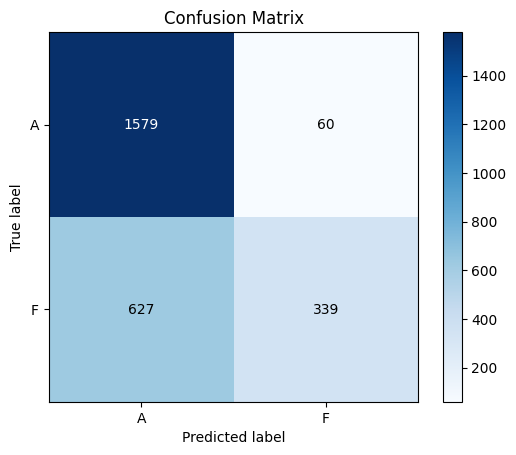

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import scikitplot as skplt

# Tách features và labels
X = X_full_AF.drop('label', axis=1)
y = y_full_AF

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Xây dựng và huấn luyện mô hình Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Dự đoán nhãn cho dữ liệu kiểm tra
y_pred = rf_model.predict(X_test)

# Đánh giá hiệu suất của mô hình
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# In báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, y_pred))

skplt.metrics.plot_confusion_matrix(y_test, y_pred)


# Classification RF vs DWT+RBP

In [ ]:
# Tìm chỉ mục của các mẫu không phải là 'F'
indices = combined_features_df[combined_features_df['label'] != 'F'].index

# Lấy dữ liệu mới mà loại bỏ các mẫu có nhãn là 'F'
X_full_ACc = combined_features_df.loc[indices]
y_full_ACc = combined_features_df['label'].loc[indices]


In [ ]:
# Tìm chỉ mục của các mẫu không phải là 'A'
indices = combined_features_df[combined_features_df['label'] != 'A'].index

# Lấy dữ liệu mới mà loại bỏ các mẫu có nhãn là 'A'
X_full_FCc = combined_features_df.loc[indices]
y_full_FCc = combined_features_df['label'].loc[indices]

In [ ]:
# Tìm chỉ mục của các mẫu không phải là 'C'
indices = combined_features_df[combined_features_df['label'] != 'C'].index

# Lấy dữ liệu mới mà loại bỏ các mẫu có nhãn là 'C'
X_full_AFc = combined_features_df.loc[indices]
y_full_AFc = combined_features_df['label'].loc[indices]

Accuracy: 0.8421226104152933
Classification Report:
              precision    recall  f1-score   support

           A       0.82      0.92      0.87      1702
           C       0.88      0.75      0.81      1332

    accuracy                           0.84      3034
   macro avg       0.85      0.83      0.84      3034
weighted avg       0.85      0.84      0.84      3034



<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

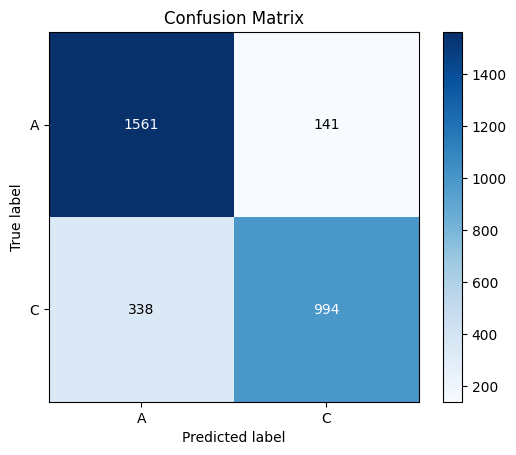

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import scikitplot as skplt

# Tách features và labels
X = X_full_ACc.drop('label', axis=1)
y = y_full_ACc

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Xây dựng và huấn luyện mô hình Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Dự đoán nhãn cho dữ liệu kiểm tra
y_pred = rf_model.predict(X_test)

# Đánh giá hiệu suất của mô hình
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# In báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, y_pred))

skplt.metrics.plot_confusion_matrix(y_test, y_pred)


Accuracy: 0.8680465717981889
Classification Report:
              precision    recall  f1-score   support

           C       0.86      0.93      0.90      1409
           F       0.88      0.77      0.82       910

    accuracy                           0.87      2319
   macro avg       0.87      0.85      0.86      2319
weighted avg       0.87      0.87      0.87      2319



<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

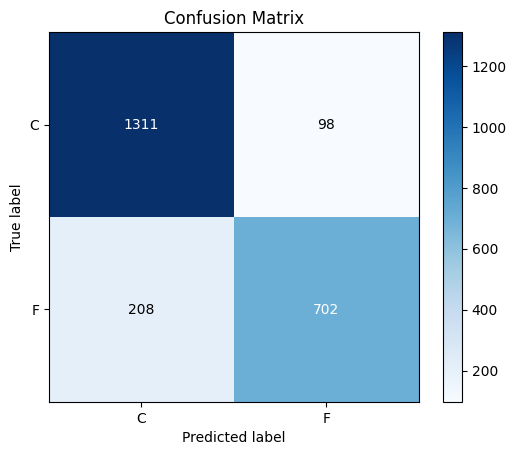

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import scikitplot as skplt

# Tách features và labels
X = X_full_FCc.drop('label', axis=1)
y = y_full_FCc

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Xây dựng và huấn luyện mô hình Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Dự đoán nhãn cho dữ liệu kiểm tra
y_pred = rf_model.predict(X_test)

# Đánh giá hiệu suất của mô hình
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# In báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, y_pred))

skplt.metrics.plot_confusion_matrix(y_test, y_pred)


Accuracy: 0.8072936660268714
Classification Report:
              precision    recall  f1-score   support

           A       0.78      0.98      0.86      1639
           F       0.93      0.52      0.67       966

    accuracy                           0.81      2605
   macro avg       0.85      0.75      0.77      2605
weighted avg       0.83      0.81      0.79      2605



<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

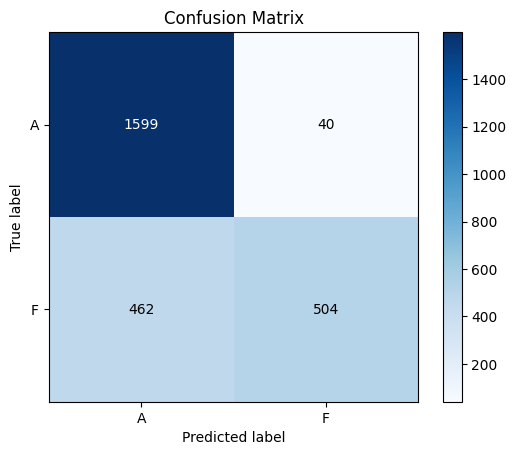

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import scikitplot as skplt

# Tách features và labels
X = X_full_AFc.drop('label', axis=1)
y = y_full_AFc

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Xây dựng và huấn luyện mô hình Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Dự đoán nhãn cho dữ liệu kiểm tra
y_pred = rf_model.predict(X_test)

# Đánh giá hiệu suất của mô hình
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# In báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, y_pred))

skplt.metrics.plot_confusion_matrix(y_test, y_pred)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Tách features và labels
X = combined_features_df.drop('label', axis=1)
y = features_df['label']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Xây dựng và huấn luyện mô hình Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Dự đoán nhãn cho dữ liệu kiểm tra
y_pred = rf_model.predict(X_test)

# Đánh giá hiệu suất của mô hình
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# In báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.7459160593113847
Classification Report:
              precision    recall  f1-score   support

           A       0.66      0.91      0.77      1652
           C       0.84      0.73      0.78      1411
           F       0.89      0.47      0.62       916

    accuracy                           0.75      3979
   macro avg       0.80      0.70      0.72      3979
weighted avg       0.78      0.75      0.74      3979

